# DBSCAN for Anomaly Detection

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a popular unsupervised clustering algorithm.  Unlike K-means, DBSCAN does not require you to specify the number of clusters beforehand. Instead, it groups together data points that are closely packed together (high density) and marks points that lie alone in low-density regions as outliers.

Key Concepts

* Epsilon (ε): The radius of the neighborhood around a data point.
* MinPts: The minimum number of data points within a neighborhood of radius ε.
* Core Point: A data point with at least MinPts within its ε-neighborhood.
* Border Point: A data point within the ε-neighborhood of a core point but has fewer than MinPts within its own ε-neighborhood.
* Noise Point: Any data point that is neither a core point nor a border point.

How DBSCAN Works

* Start with an arbitrary unvisited point.
* Retrieve all points density-reachable from this point.
* If the point is a core point, this forms a cluster.
* If the point is a border point, it is added to the cluster of its nearest core point.
* If the point is a noise point, it is left unclustered.
* Repeat the process with an unvisited point.
* The algorithm iterates until all points have been processed.

Example

Let's say we have the following 2D dataset:

[(1, 2), (1.5, 2), (2, 2), (4, 4), (4, 5), (5, 4), (8, 1), (8, 2), (9, 2), (9, 3)]

And we choose ε = 1 and MinPts = 3.

* Start with (1, 2).  The points within a radius of 1 are (1.5, 2) and (2, 2).  Since there are only 2 points (less than MinPts=3), (1, 2) is not a core point.
* Move to (1.5, 2).  The points within a radius of 1 are (1, 2), (2, 2).  Again, only 2 points, so (1.5, 2) is not a core point.
* Move to (2, 2).  The points within a radius of 1 are (1, 2), (1.5, 2).  Still only 2 points.  (2, 2) is not a core point.
* Move to (4, 4).  The points within a radius of 1 are (4, 5), (5, 4).  Only 2 points.  Not a core point.
* Move to (4, 5).  Points within radius 1: (4, 4), (5, 4).  Not a core point.
* Move to (5, 4).  Points within radius 1: (4, 4), (4, 5).  Not a core point.
* Move to (8, 1).  Points within radius 1: (8, 2), (9, 2).  Only 2 points.  Not a core point.
* Move to (8, 2).  Points within radius 1: (8, 1), (9, 2), (9, 3).  3 points!  (8, 2) is a core point.  Create cluster 1 containing (8,2), (8,1), (9,2), and (9,3)
* Move to (9, 2).  This is already in cluster 1.
* Move to (9, 3).  This is already in cluster 1.

In this example, the points (8, 1), (8, 2), (9, 2), and (9, 3) form a cluster. The points (1, 2), (1.5, 2), (2, 2), (4, 4), (4, 5), and (5, 4) are border points.

# Notebook Walkthrough

1. Import necessary dependencies
2. Import the dataset and perform initial analysis
3. Data preparation for cluster analysis
4. Optimized version of DBSCAN model with multiple values of eps and min_samples

# 1. Import necessary dependencies

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Import the dataset and perform initial analysis

In [34]:
df = pd.read_csv('entertainment.csv')

In [35]:
df.head()

,name,books,tv_shows,video_games
0,Aaliyah,0.5,4.6,4.9
1,Abigail,0.0,4.5,4.8
2,Addison,0.5,4.5,5.0
3,Adeline,3.5,4.5,6.6
4,Alana,2.8,3.8,5.6


In [36]:
df.shape

(150, 4)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         150 non-null    object 
 1   books        150 non-null    float64
 2   tv_shows     150 non-null    float64
 3   video_games  150 non-null    float64
dtypes: float64(3), object(1)
memory usage: 4.8+ KB


In [38]:
df.describe()

,books,tv_shows,video_games
count,150.000000,150.000000,150.000000
mean,2.993333,4.586000,5.843333
std,1.917761,0.645587,0.828066
min,0.000000,3.000000,4.300000
25%,0.800000,4.200000,5.100000
50%,3.200000,4.500000,5.800000
75%,4.500000,4.900000,6.400000
max,6.200000,6.600000,7.900000


### Univariate analysis of the numerical columns

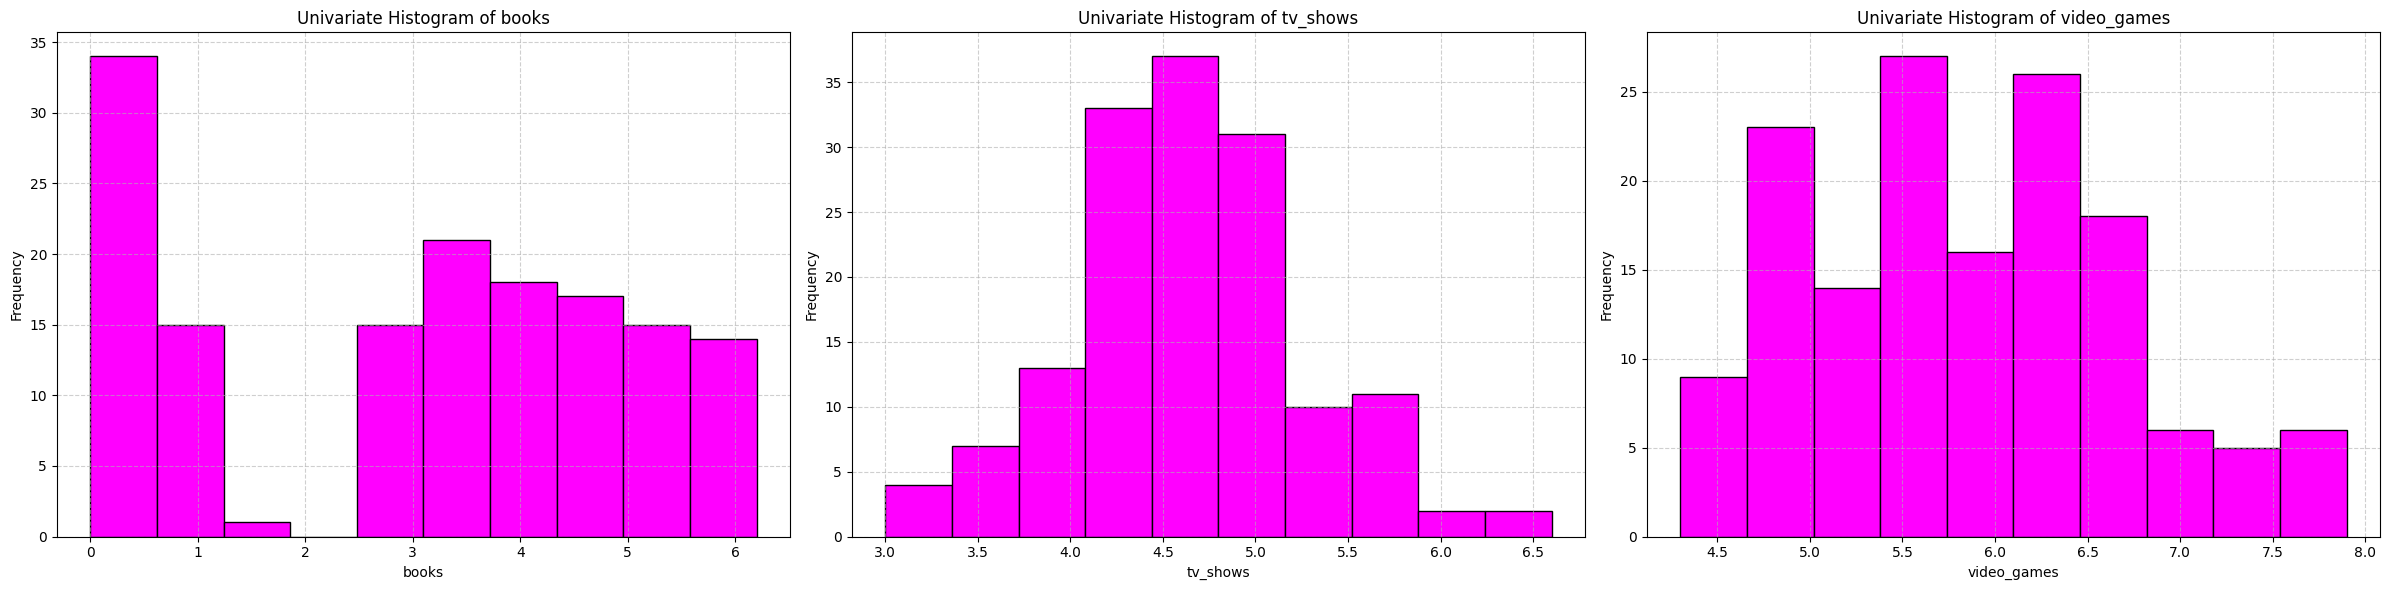

In [39]:
# List of the columns you want to create histograms for
columns_to_plot = ['books', 'tv_shows', 'video_games']

# Create a figure and a set of subplots
num_plots = len(columns_to_plot)
fig, axes = plt.subplots(1, num_plots, figsize=(8 * num_plots, 6))  # Adjust figure width

# Create a histogram for each specified column in its respective subplot
for i, column in enumerate(columns_to_plot):
    ax = axes[i]  # Select the current subplot
    df[column].hist(bins=10,color = 'magenta' , edgecolor='black', ax=ax)  # Use the 'ax' argument
    ax.set_title(f'Univariate Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.show()

### Summarizing the insights

1. Books:

* The distribution for "books" appears to be right-skewed.
* There's a high frequency of individuals with very low scores (around 0-1).
* The frequency then decreases, with smaller peaks around the 3-4 range and then again around the 5-6 range.
* This suggests that most individuals in this dataset have a low affinity for books based on this metric, with fewer individuals showing higher levels of engagement.

2. TV Shows:

* The distribution for "tv_shows" seems to be approximately normal or slightly left-skewed.
* The highest frequency of individuals falls in the range of around 4.5 to 5.0. There are noticeable frequencies around the 4.0-4.5 range as well.
* The frequencies tend to decrease as the scores move away from this central tendency towards both lower and higher values.
* This suggests a relatively consistent and moderate level of engagement with TV shows across the individuals in the dataset.

3. Video Games:

* The distribution for "video games" appears to be multimodal, with several peaks.
* There are noticeable peaks in frequency around the 4.5-5.0 range, the 5.5-6.0 range, and possibly a smaller one around the 7.0-7.5 range.
* There are also lower frequencies in the ranges between these peaks.
* This indicates that there are distinct groups of individuals with different levels of engagement with video games, rather than a single central tendency.

In summary:

* Engagement with books is generally low, with a few individuals showing higher engagement.
* Engagement with TV shows is more consistent and centered around a moderate level.
* Engagement with video games shows distinct groups with varying levels of affinity, suggesting different preferences within the dataset.

# 3. Data preparation for Anomaly Detection

* Row granularity : For DBSCAN on user behavior, row granularity should represent individual users with a single entry summarizing their relevant actions to ensure each cluster captures distinct groups of users based on their overall behavioral patterns rather than individual actions.
* Missing value identification and handling : Missing values in DBSCAN need careful identification and handling (e.g., imputation or removal) because the algorithm relies on distance calculations, which are undefined with missing data, thus potentially leading to inaccurate clustering.
* Verify if all columns are numeric in nature : Before applying DBSCAN, it's crucial to verify that all columns used for clustering are numeric because the algorithm calculates distances based on numerical values.
* feature selection : Feature selection in DBSCAN aims to identify the most relevant variables that effectively differentiate user behavior, leading to more meaningful and interpretable clusters.
* feature scaling : Feature scaling is essential in DBSCAN to ensure that features with larger ranges do not disproportionately influence the distance calculations and cluster assignments, allowing all features to contribute equally to the clustering process.

### 1. Row granularity

In [41]:
df.name.nunique() , df.shape

(150, (150, 4))

So their are 150 unique names which matches the rows in the dataset , so we are at the right level of granularity

### 2. Missing value identification and handling

In [42]:
df.isnull().sum()

,0
name,0
books,0
tv_shows,0
video_games,0


The data is clean , no missing value to handle

### 3. Verify if all columns are numeric in nature

In [43]:
df.dtypes

,0
name,object
books,float64
tv_shows,float64
video_games,float64


All columns are numeric in nature , other than name

### 4. feature selection ( Drop the name column )

In [44]:
data = df.drop(columns=['name'])

In [45]:
data

,books,tv_shows,video_games
0,0.5,4.6,4.9
1,0.0,4.5,4.8
2,0.5,4.5,5.0
3,3.5,4.5,6.6
4,2.8,3.8,5.6
...,...,...,...
145,5.2,4.6,6.9
146,6.0,4.6,6.7
147,5.5,5.7,7.7
148,0.0,6.1,5.2


# 4. Optimized version of DBSCAN model with multiple values of eps and min_samples

### Explore different DBSCAN models with different values of eps and min_samples values

1. Libraries

import numpy as np: Imports the NumPy library, which provides support for numerical operations, including creating arrays.

2. Initialization

results = []: Initializes an empty list called results. This list will be used to store the results of the DBSCAN clustering for different parameter combinations.

3. Parameter Ranges

* eps_values = np.arange(.1, 2, .1): Creates a NumPy array named eps_values containing a range of epsilon (ε) values from 0.1 to 2 (exclusive), with a step of 0.1. Epsilon defines the radius of the neighborhood around a data point.
* min_samples_values = np.arange(2, 10, 1): Creates a NumPy array named min_samples_values containing a range of integer values from 2 to 10 (exclusive), with a step of 1. min_samples defines the minimum number of data points that must be within a point's ε-neighborhood for that point to be considered a core point.

4. Nested Loops

The code then enters a nested loop:

* The outer loop iterates through each eps value in eps_values.
* The inner loop iterates through each min_samples value in min_samples_values.
* For each combination of eps and min_samples, the following steps are performed:

DBSCAN Clustering

* dbscan = DBSCAN(eps=eps, min_samples=min_samples): Creates a DBSCAN object with the current eps and min_samples values.
* dbscan.fit(data): Fits the DBSCAN model to the data (the variable data is assumed to be defined elsewhere in your code). This performs the clustering.
* labels = dbscan.labels_: Retrieves the cluster labels assigned by DBSCAN to each data point. The labels are stored in the labels variable. Points labeled '-1' are considered noise.

5. Cluster and Noise Analysis

* n_clusters = len(set(labels)) - (1 if -1 in labels else 0): Calculates the number of clusters.
* set(labels) gets the unique labels.
* len(set(labels)) counts the number of unique labels.
* The expression (1 if -1 in labels else 0) checks if there are any noise points (labeled as -1). If there are, it subtracts 1 from the count (because noise points are not considered a cluster); otherwise, it subtracts 0.
* n_noise = list(labels).count(-1): Counts the number of data points labeled as noise (-1) in the labels list.

6. Silhouette Score Calculation

* The code calculates the silhouette score, a measure of how well each data point fits within its cluster.
* if n_clusters > 1: Checks if the number of clusters is greater than 1. The silhouette score is not defined for a single cluster.
* silhouette = silhouette_score(data, labels, metric='euclidean', sample_size=None): If there are two or more clusters, the silhouette score is calculated using the data, the cluster labels, the Euclidean distance metric, and all data points.
* else: silhouette = None: If there is only one cluster (or zero), the silhouette score is set to None.

7. Storing Results

* results.append([eps, min_samples, n_clusters, n_noise, silhouette]): The current values of eps, min_samples, the number of clusters, the number of noise points, and the silhouette score are appended as a list to the results list.

8. Creating a DataFrame

* dbscan_results = pd.DataFrame(results, columns=["Eps", "Min Samples", "Number of Clusters", "Number of Noise Points", "Silhouette Score"]): After the loops have finished, the results list (which contains the results for all the different parameter combinations) is converted into a pandas DataFrame.
* The DataFrame has columns named "Eps", "Min Samples", "Number of Clusters", "Number of Noise Points", and "Silhouette Score".
* dbscan_results.head(): print the first 5 rows of the dataframe.

### A. Automate the DBSCAN Model Optimization process through a utility function

We have converted the above code as a utility function , which takes a dataframe and returns a dataframe with multiple execution of the DBSCAN model with different values of eps and min_samples

In [46]:
# put the entire process into a function
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

def tune_dbscan(data):

    results = []

    # define a range of eps and min_samples values to loop through
    eps_values = np.arange(.1, 2, .1)
    min_samples_values = np.arange(2, 10, 1)

    # loop through the combinations of eps and min_samples
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan.fit(data)
            labels = dbscan.labels_

            # count the number of clusters (excluding noise points labeled as -1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            # count the number of noise points (labeled as -1)
            n_noise = list(labels).count(-1)

            # calculate the silhouette score
            if n_clusters > 1:  # silhouette score requires at least 2 clusters
                silhouette = silhouette_score(data, labels, metric='euclidean', sample_size=None)
            else:
                silhouette = None

            results.append([eps, min_samples, n_clusters, n_noise, silhouette])

    # put the results in a dataframe
    dbscan_results = pd.DataFrame(results, columns=["Eps", "Min Samples", "Number of Clusters",
                                                    "Number of Noise Points", "Silhouette Score"])
    return dbscan_results

In [47]:
# view the results on the original data

dbscan_results = tune_dbscan(data)
dbscan_results.head()

,Eps,Min Samples,Number of Clusters,Number of Noise Points,Silhouette Score
0,0.1,2,12,124,-0.438782
1,0.1,3,2,144,-0.483479
2,0.1,4,0,150,NaN
3,0.1,5,0,150,NaN
4,0.1,6,0,150,NaN


In [48]:
# top silhouette scores

dbscan_results.sort_values(by='Silhouette Score', ascending=False).head()

,Eps,Min Samples,Number of Clusters,Number of Noise Points,Silhouette Score
109,1.4,7,2,0,0.628673
110,1.4,8,2,0,0.628673
111,1.4,9,2,0,0.628673
112,1.5,2,2,0,0.628673
113,1.5,3,2,0,0.628673


In [49]:
# return one eps + min_samples combo for each silhouette score

(dbscan_results.sort_values('Silhouette Score', ascending=False)
               .groupby('Silhouette Score')
               .head(1)).head(10)

,Eps,Min Samples,Number of Clusters,Number of Noise Points,Silhouette Score
109,1.4,7,2,0,0.628673
77,1.0,7,2,2,0.550831
66,0.9,4,2,3,0.528540
72,1.0,2,2,1,0.515323
57,0.8,3,2,4,0.497686
59,0.8,5,2,5,0.482653
43,0.6,5,2,12,0.480329
52,0.7,6,2,9,0.476795
42,0.6,4,2,11,0.476287
63,0.8,9,2,6,0.471959


Since we are looking for outliers(Noise Points) , we will choose eps = 1 and min_samples = 7 , since it has 2 noise points

In [54]:
# fit a dbscan model

dbscan = DBSCAN(eps=1, min_samples=6)
dbscan.fit(data)

DBSCAN(eps=1, min_samples=6)

In [55]:
pd.Series(dbscan.labels_).value_counts()

,count
1,99
0,49
-1,2


As highlighted above 2 datapoints are flagged as anomalies

In [56]:
# view the cluster assignments
dbscan.labels_

array([ 0,  0,  0,  1,  1,  1,  1,  1,  0,  1,  1,  0,  0,  0,  0,  0,  1,
        0,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  0,  1,  1,  1,  0,  0,  1,  1,  0,  1,  0,  1,  1,
        1,  1,  1,  1,  1,  0,  1,  1,  1,  0,  0,  0,  1,  1,  1,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,
        1,  1,  0,  0,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  0,
        1,  1,  1,  1,  0,  1,  0,  0, -1,  1,  0,  0,  0,  1,  1,  0,  1,
        1,  1,  1,  0,  0,  0,  1,  1,  1,  1,  0,  0,  0,  1,  0,  1,  1,
        1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  1,  1,  0,  0])

In [58]:
# Note the anomalies (-1) and visualize them on a pair plot
df['anomaly_dbscan'] = dbscan.labels_
df.head()

,name,books,tv_shows,video_games,anomaly_dbscan
0,Aaliyah,0.5,4.6,4.9,0
1,Abigail,0.0,4.5,4.8,0
2,Addison,0.5,4.5,5.0,0
3,Adeline,3.5,4.5,6.6,1
4,Alana,2.8,3.8,5.6,1


In [59]:
# Highlighting the rows flagged as outliers

df[df['anomaly_dbscan'] == -1]

,name,books,tv_shows,video_games,anomaly_dbscan
37,Elena,0.8,3.4,4.5,-1
110,Octavia,5.0,5.7,7.9,-1


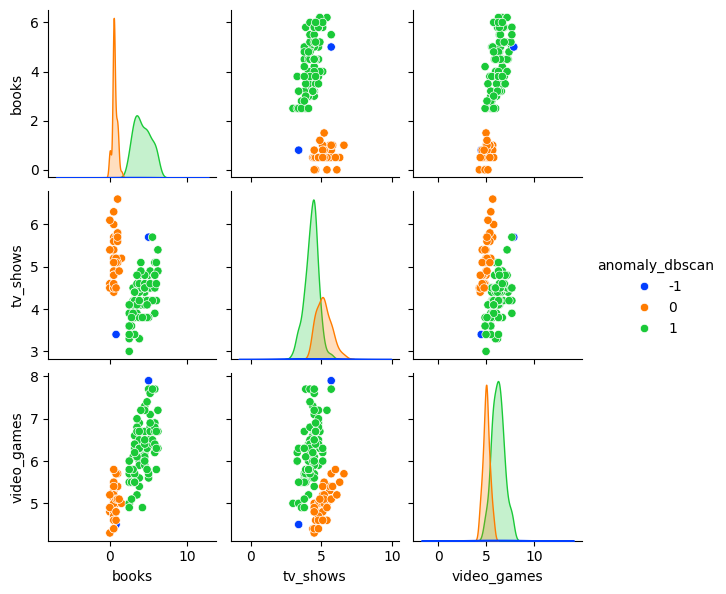

In [60]:
# create a pair plot

sns.pairplot(df[['books', 'tv_shows', 'video_games', 'anomaly_dbscan']], hue='anomaly_dbscan', palette='bright', height=2);

Now the following rows can be studied and based on business requirement downstream action can be taken